# 서울시 CCTV 및 범죄발생 현황분석


### 요약
- 본 분석은 서울시 CCTV 설치 현황(2018)과 인구현황(2020), 범죄 발생 데이터를 활용하여 진행하였다.
- 3년간의 CCTV가 2015년 이전에 비해 가장 많이 증가한 곳은 중구, 영등포구, 성동구, 금천구 순이다.
- 인구 대비 CCTV 설치로 회귀선을 이용하여 강남구, 관악구, 구로구는 과다 설치를 송파구, 강서구, 노원구는 CCTV가 필요한 것으로 보았다.
- 범죄 발생의 데이터는 각 컬럼(강간, 강도, 살인, 폭력, 절도)의 수치 기준이 다르므로 정규화(Normalize)을 실시했다.
- 강도와 폭력, 살인과 폭력, 강도와 살인 모두 양의 상관관계로 강도의 건수가 많아지면 폭력과 살인의 발생건수도 많아진다.
- 인구 수가 증가하면 살인과 강도의 발생 수도 증가하고 강도 보다는 살인 발생 수가 훨씬 많이 증가한다.  
- CCTV와 살인은 상관관계가 있으므로 CCTV가 없을 때 살인 사건 발생 수가 증가한다..
- 인구수가 많아 질수록 폭력 검거율은 줄어들고 CCTV가 많아 질수록 모든 검거율이 낮아집니다.


### 결론
- CCTV와 범죄는 상관관계(0.48)가 있으며  
- CCTV가 많다고 해서 꼭 범죄 발생이 감소 하는 것은 아니다.
- 서울 내에서 CCTV가 가장 많은 자치구는 강남구(5221대)이며 범죄(4.8)로 가장 높다.
- 머신러닝을 통한 인구증가량에 따른 CCTV 증가량 예측이 가능할 것 같다.

In [83]:
import pandas as pd
import numpy as np

# CCTV 설치 현황

In [84]:
CCTV_Seoul = pd.read_excel('./Data/CCTV_in_Seoul_2018.xlsx', engine = 'openpyxl')
CCTV_Seoul.head()

,기관명,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
0,강남구,5221,1944.0,195.0,316.0,430,546,765,577,448
1,강동구,1879,303.0,387.0,134.0,59,144,194,273,385
2,강북구,1265,243.0,88.0,141.0,74,145,254,1,319
3,강서구,1617,219.0,155.0,118.0,230,187,190,264,254
4,관악구,3985,430.0,56.0,419.0,487,609,619,694,671


In [85]:
# Column명 확인
CCTV_Seoul.columns

Index(['기관명', '소계', '2011년 이전', '2012년', '2013년', '2014년', '2015년', '2016년',
       '2017년', '2018년'],
      dtype='object')

In [86]:
CCTV_Seoul.columns[0]

'기관명'

In [87]:
# 컬럼 중 제일 처음에 있는 기관명을 구별로 변경
CCTV_Seoul = CCTV_Seoul.rename(columns={'기관명':'구별'})
CCTV_Seoul.columns

Index(['구별', '소계', '2011년 이전', '2012년', '2013년', '2014년', '2015년', '2016년',
       '2017년', '2018년'],
      dtype='object')

In [88]:
# 2011년 이전의 NaN데이터 위치 및 갯수 파악
CCTV_Seoul[CCTV_Seoul['2011년 이전'].isnull()]

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
10,동대문구,2003,NaN,NaN,NaN,1326,111,233,136,197
24,중랑구,1068,NaN,NaN,NaN,770,102,121,66,9


In [89]:
# 2011년 이전의 NaN데이터 위치 및 갯수 파악
CCTV_Seoul.iloc[:,2][CCTV_Seoul.iloc[:,2].isnull()]

10   NaN
24   NaN
Name: 2011년 이전, dtype: float64

In [90]:
for i in CCTV_Seoul.iloc[:,2:]:
    print(i,' : %5d'%len(CCTV_Seoul[CCTV_Seoul[i].isnull()]))

2011년 이전  :     2
2012년  :     2
2013년  :     2
2014년  :     0
2015년  :     0
2016년  :     0
2017년  :     0
2018년  :     0


In [91]:
# NaN을 0으로 변환하기
CCTV_Seoul = CCTV_Seoul.fillna(0)


---
# 인구데이터 불러오기


In [92]:
pop_seoul = pd.read_excel('./Data/population_in_Seoul_2020.xlsx', engine = 'openpyxl', )
pop_seoul

,report,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,기간,자치구,세대,인구,인구,인구,인구,인구,인구,인구,인구,인구,세대당인구,65세이상고령자
1,기간,자치구,세대,합계,합계,합계,한국인,한국인,한국인,등록외국인,등록외국인,등록외국인,세대당인구,65세이상고령자
2,기간,자치구,세대,계,남자,여자,계,남자,여자,계,남자,여자,세대당인구,65세이상고령자
3,2020.1/4,합계,4354006,10013781,4874995,5138786,9733655,4742217,4991438,280126,132778,147348,2.24,1518239
4,2020.1/4,종로구,74151,161984,78271,83713,151217,73704,77513,10767,4567,6200,2.04,28073
5,2020.1/4,중구,63045,136469,66769,69700,126175,61839,64336,10294,4930,5364,2,23794
6,2020.1/4,용산구,110895,246165,119961,126204,229579,110667,118912,16586,9294,7292,2.07,39439
7,2020.1/4,성동구,135643,307193,149891,157302,299042,146300,152742,8151,3591,4560,2.2,44728
8,2020.1/4,광진구,165287,365990,176226,189764,350417,169568,180849,15573,6658,8915,2.12,48989
9,2020.1/4,동대문구,165279,362793,178202,184591,346156,171896,174260,16637,6306,10331,2.09,60367


In [93]:
# 필요한 컬럼 B(자치구), D(합계), G(한국인 계), J(등록 외국인계), N(65세 이상)
pop_Seoul = pd.read_excel('./Data/population_in_Seoul_2020.xlsx', header= 3, usecols='B,D,G,J,N')
pop_Seoul

,자치구,계,계.1,계.2,65세이상고령자
0,합계,10013781,9733655,280126,1518239
1,종로구,161984,151217,10767,28073
2,중구,136469,126175,10294,23794
3,용산구,246165,229579,16586,39439
4,성동구,307193,299042,8151,44728
5,광진구,365990,350417,15573,48989
6,동대문구,362793,346156,16637,60367
7,중랑구,400678,395619,5059,66764
8,성북구,454532,442494,12038,72172
9,강북구,316750,312985,3765,61660


In [94]:
pop_Seoul.columns = ['구별','인구수','한국인','외국인','고령자']
pop_Seoul

,구별,인구수,한국인,외국인,고령자
0,합계,10013781,9733655,280126,1518239
1,종로구,161984,151217,10767,28073
2,중구,136469,126175,10294,23794
3,용산구,246165,229579,16586,39439
4,성동구,307193,299042,8151,44728
5,광진구,365990,350417,15573,48989
6,동대문구,362793,346156,16637,60367
7,중랑구,400678,395619,5059,66764
8,성북구,454532,442494,12038,72172
9,강북구,316750,312985,3765,61660


In [95]:
# 합계 행을 삭제
pop_Seoul.drop([0],inplace=True)
pop_Seoul

,구별,인구수,한국인,외국인,고령자
1,종로구,161984,151217,10767,28073
2,중구,136469,126175,10294,23794
3,용산구,246165,229579,16586,39439
4,성동구,307193,299042,8151,44728
5,광진구,365990,350417,15573,48989
6,동대문구,362793,346156,16637,60367
7,중랑구,400678,395619,5059,66764
8,성북구,454532,442494,12038,72172
9,강북구,316750,312985,3765,61660
10,도봉구,333495,331238,2257,60023


In [96]:
# CCTV 소계로 오름차순 정렬
CCTV_Seoul.sort_values(by='소계', ascending=True).head()

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
9,도봉구,858,197.0,66.0,8.0,185,59,155,117,71
24,중랑구,1068,0.0,0.0,0.0,770,102,121,66,9
2,강북구,1265,243.0,88.0,141.0,74,145,254,1,319
22,종로구,1471,8.0,7.0,599.0,132,195,148,281,101
23,중구,1544,25.0,165.0,114.0,80,245,270,317,328


> CCTV 댓수가 적은 지역으로는 도봉구, 중랑구, 강북구, 종로구, 중구, 광진구 순이다.

In [97]:
# CCTV 소계로 오름차순 정렬
CCTV_Seoul.sort_values(by='소계', ascending=False).head()

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년
0,강남구,5221,1944.0,195.0,316.0,430,546,765,577,448
4,관악구,3985,430.0,56.0,419.0,487,609,619,694,671
6,구로구,3227,852.0,219.0,349.0,187,268,326,540,486
16,성북구,3003,779.0,84.0,304.0,241,279,388,285,643
21,은평구,2962,1365.0,83.0,99.0,343,180,296,229,367


> CCTV 댓수가 많은 지역으로는 강남구, 관악구, 구로구, 성북구, 은평구 순이다.

### 3년간 CCTV증가율을 구해서 CCTV가 제일 많이 증가한 구를 검색

In [98]:
# 최근 증가율 : 최근 3년치 CCTV 개수(2016~2018)를 더하고 나머지 년도의 CCTV 댓수의 합으로 나누어 100으로 곱한다.
CCTV_Seoul['최근 증가율'] = (CCTV_Seoul.iloc[:,7:10].sum(axis=1)) / CCTV_Seoul.iloc[:,2:7].sum(axis =1) *100
CCTV_Seoul.sort_values(by = '최근 증가율', ascending=False)

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년,최근 증가율
23,중구,1544,25.0,165.0,114.0,80,245,270,317,328,145.468998
19,영등포구,2495,132.0,121.0,206.0,217,366,289,371,793,139.443378
15,성동구,2679,665.0,109.0,118.0,101,258,201,933,294,114.148681
7,금천구,1634,27.0,17.0,242.0,101,382,136,199,530,112.483745
5,광진구,1581,470.0,42.0,83.0,87,64,21,468,346,111.930295
4,관악구,3985,430.0,56.0,419.0,487,609,619,694,671,99.150425
12,마포구,1935,585.0,108.0,69.0,70,177,359,372,195,91.774034
18,양천구,2775,772.0,161.0,185.0,169,172,349,137,830,90.198766
2,강북구,1265,243.0,88.0,141.0,74,145,254,1,319,83.068017
1,강동구,1879,303.0,387.0,134.0,59,144,194,273,385,82.960078


> 결과를 보면 3년간의 CCTV가 2015년 이전에 비해 가장 많이 증가한 곳은 중구, 영등포구, 성동구, 금천구 순이다.

---
# 인구현황

In [99]:
pop_Seoul.head()

,구별,인구수,한국인,외국인,고령자
1,종로구,161984,151217,10767,28073
2,중구,136469,126175,10294,23794
3,용산구,246165,229579,16586,39439
4,성동구,307193,299042,8151,44728
5,광진구,365990,350417,15573,48989


In [100]:
# 구별 항목의 유일성 확인
pop_Seoul['구별'].unique()

array(['종로구', '중구', '용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구',
       '도봉구', '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구',
       '영등포구', '동작구', '관악구', '서초구', '강남구', '송파구', '강동구'], dtype=object)

In [101]:
len(pop_Seoul['구별'].unique())

25

In [102]:
# 고령자 비율과 외국인 비율 계산 후 적용
pop_Seoul['외국인비율'] = pop_Seoul['외국인'] / pop_Seoul['인구수']
pop_Seoul['고령자비율'] = pop_Seoul['고령자'] / pop_Seoul['인구수']
pop_Seoul

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
1,종로구,161984,151217,10767,28073,0.066470,0.173307
2,중구,136469,126175,10294,23794,0.075431,0.174355
3,용산구,246165,229579,16586,39439,0.067378,0.160214
4,성동구,307193,299042,8151,44728,0.026534,0.145602
5,광진구,365990,350417,15573,48989,0.042550,0.133853
6,동대문구,362793,346156,16637,60367,0.045858,0.166395
7,중랑구,400678,395619,5059,66764,0.012626,0.166628
8,성북구,454532,442494,12038,72172,0.026484,0.158783
9,강북구,316750,312985,3765,61660,0.011886,0.194665
10,도봉구,333495,331238,2257,60023,0.006768,0.179982


In [103]:
# 인구수 기준 내림차순 정렬
pop_Seoul.sort_values(by='인구수', ascending=False)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
24,송파구,680883,674095,6788,89539,0.009969,0.131504
16,강서구,595703,589302,6401,85992,0.010745,0.144354
23,강남구,549898,544804,5094,72602,0.009264,0.132028
11,노원구,535495,531037,4458,82682,0.008325,0.154403
21,관악구,516662,499374,17288,76664,0.033461,0.148383
12,은평구,482509,478019,4490,82245,0.009306,0.170453
15,양천구,460532,456339,4193,62761,0.009105,0.136279
25,강동구,457042,452646,4396,66401,0.009618,0.145284
8,성북구,454532,442494,12038,72172,0.026484,0.158783
17,구로구,438308,405837,32471,67432,0.074083,0.153846


In [104]:
# 외국인 기준 내림차순 정렬
pop_Seoul.sort_values(by='외국인', ascending=False)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
19,영등포구,404766,371903,32863,59373,0.081190,0.146685
17,구로구,438308,405837,32471,67432,0.074083,0.153846
18,금천구,251370,232583,18787,38508,0.074738,0.153193
21,관악구,516662,499374,17288,76664,0.033461,0.148383
6,동대문구,362793,346156,16637,60367,0.045858,0.166395
3,용산구,246165,229579,16586,39439,0.067378,0.160214
5,광진구,365990,350417,15573,48989,0.042550,0.133853
13,서대문구,325875,312642,13233,53038,0.040608,0.162756
20,동작구,407802,395014,12788,63378,0.031358,0.155414
8,성북구,454532,442494,12038,72172,0.026484,0.158783


In [105]:
# 외국인 비율 기준 내림차순 정렬
pop_Seoul.sort_values(by='외국인비율', ascending=False)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
19,영등포구,404766,371903,32863,59373,0.081190,0.146685
2,중구,136469,126175,10294,23794,0.075431,0.174355
18,금천구,251370,232583,18787,38508,0.074738,0.153193
17,구로구,438308,405837,32471,67432,0.074083,0.153846
3,용산구,246165,229579,16586,39439,0.067378,0.160214
1,종로구,161984,151217,10767,28073,0.066470,0.173307
6,동대문구,362793,346156,16637,60367,0.045858,0.166395
5,광진구,365990,350417,15573,48989,0.042550,0.133853
13,서대문구,325875,312642,13233,53038,0.040608,0.162756
21,관악구,516662,499374,17288,76664,0.033461,0.148383


In [106]:
# 고령자 기준 내림차순 정렬
pop_Seoul.sort_values(by='고령자', ascending=False)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
24,송파구,680883,674095,6788,89539,0.009969,0.131504
16,강서구,595703,589302,6401,85992,0.010745,0.144354
11,노원구,535495,531037,4458,82682,0.008325,0.154403
12,은평구,482509,478019,4490,82245,0.009306,0.170453
21,관악구,516662,499374,17288,76664,0.033461,0.148383
23,강남구,549898,544804,5094,72602,0.009264,0.132028
8,성북구,454532,442494,12038,72172,0.026484,0.158783
17,구로구,438308,405837,32471,67432,0.074083,0.153846
7,중랑구,400678,395619,5059,66764,0.012626,0.166628
25,강동구,457042,452646,4396,66401,0.009618,0.145284


In [107]:
# 고령자 비율 기준 내림차순 정렬
pop_Seoul.sort_values(by='고령자비율', ascending=False)

,구별,인구수,한국인,외국인,고령자,외국인비율,고령자비율
9,강북구,316750,312985,3765,61660,0.011886,0.194665
10,도봉구,333495,331238,2257,60023,0.006768,0.179982
2,중구,136469,126175,10294,23794,0.075431,0.174355
1,종로구,161984,151217,10767,28073,0.066470,0.173307
12,은평구,482509,478019,4490,82245,0.009306,0.170453
7,중랑구,400678,395619,5059,66764,0.012626,0.166628
6,동대문구,362793,346156,16637,60367,0.045858,0.166395
13,서대문구,325875,312642,13233,53038,0.040608,0.162756
3,용산구,246165,229579,16586,39439,0.067378,0.160214
8,성북구,454532,442494,12038,72172,0.026484,0.158783


> 인구수가 제일 많은 지역은 송파구 이지만, 영등포구가 외국인이 제일 많다.    
> 그리고 그 근처라고 할 수 있는 구로구, 금천구 등도 외국인이 많다.    
> 송파구는 고령자가 제일 많지만 고령자의 비율이 높지 않은 것이 확인된다.    
> 하지만 강북구, 도봉구, 중구, 종로구, 은평구 같은 경우는 인구 수 대비    
> 고령자 비율이 많기 때문에 추후 고령자가 우려된다.    

# CCTV와 인구현황 합치기

In [108]:
# CCTV와 인구현황 데이터 합치기

In [109]:
data_result = pd.merge(CCTV_Seoul,pop_Seoul, on = '구별')
data_result.head()

,구별,소계,2011년 이전,2012년,2013년,2014년,2015년,2016년,2017년,2018년,최근 증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,5221,1944.0,195.0,316.0,430,546,765,577,448,52.171379,549898,544804,5094,72602,0.009264,0.132028
1,강동구,1879,303.0,387.0,134.0,59,144,194,273,385,82.960078,457042,452646,4396,66401,0.009618,0.145284
2,강북구,1265,243.0,88.0,141.0,74,145,254,1,319,83.068017,316750,312985,3765,61660,0.011886,0.194665
3,강서구,1617,219.0,155.0,118.0,230,187,190,264,254,77.887789,595703,589302,6401,85992,0.010745,0.144354
4,관악구,3985,430.0,56.0,419.0,487,609,619,694,671,99.150425,516662,499374,17288,76664,0.033461,0.148383


In [110]:
# 반복문을 이용한 년도별 CCTV 컬럼 삭제
for i in data_result.iloc[:,2:10]:
    data_result = data_result.drop([i], axis=1)
data_result

,구별,소계,최근 증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
0,강남구,5221,52.171379,549898,544804,5094,72602,0.009264,0.132028
1,강동구,1879,82.960078,457042,452646,4396,66401,0.009618,0.145284
2,강북구,1265,83.068017,316750,312985,3765,61660,0.011886,0.194665
3,강서구,1617,77.887789,595703,589302,6401,85992,0.010745,0.144354
4,관악구,3985,99.150425,516662,499374,17288,76664,0.033461,0.148383
5,광진구,1581,111.930295,365990,350417,15573,48989,0.042550,0.133853
6,구로구,3227,72.106667,438308,405837,32471,67432,0.074083,0.153846
7,금천구,1634,112.483745,251370,232583,18787,38508,0.074738,0.153193
8,노원구,1906,42.026826,535495,531037,4458,82682,0.008325,0.154403
9,도봉구,858,66.601942,333495,331238,2257,60023,0.006768,0.179982


In [111]:
# 인덱스를 구별로 지정
data_result.set_index('구별',inplace=True)
data_result

,소계,최근 증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,5221,52.171379,549898,544804,5094,72602,0.009264,0.132028
강동구,1879,82.960078,457042,452646,4396,66401,0.009618,0.145284
강북구,1265,83.068017,316750,312985,3765,61660,0.011886,0.194665
강서구,1617,77.887789,595703,589302,6401,85992,0.010745,0.144354
관악구,3985,99.150425,516662,499374,17288,76664,0.033461,0.148383
광진구,1581,111.930295,365990,350417,15573,48989,0.042550,0.133853
구로구,3227,72.106667,438308,405837,32471,67432,0.074083,0.153846
금천구,1634,112.483745,251370,232583,18787,38508,0.074738,0.153193
노원구,1906,42.026826,535495,531037,4458,82682,0.008325,0.154403


---
# 상관계수
: Numpy

In [113]:
# 고령자 비율과 소계의 상관계수
np.corrcoef(data_result['고령자비율'],data_result['소계'])

array([[ 1.        , -0.44225083],
       [-0.44225083,  1.        ]])

In [115]:
# 외국인 비율과 소계의 상관계수
np.corrcoef(data_result['외국인비율'],data_result['소계'])

array([[ 1.        , -0.06215538],
       [-0.06215538,  1.        ]])

In [114]:
# 인구수와 소계의 상관계수
np.corrcoef(data_result['인구수'],data_result['소계'])

array([[1.        , 0.38064812],
       [0.38064812, 1.        ]])

> 고령자비율, 외국인비율, 인구수를 비교해보았을때 고령자 비율과는 음의 상관이 발생하고 인구수와 소계는 양의 상관이 있다고 말할 수 있다.

In [117]:
# CCTV 소계의 내림차순
data_result.sort_values(by='소계', ascending=False).head()

,소계,최근 증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,5221,52.171379,549898,544804,5094,72602,0.009264,0.132028
관악구,3985,99.150425,516662,499374,17288,76664,0.033461,0.148383
구로구,3227,72.106667,438308,405837,32471,67432,0.074083,0.153846
성북구,3003,78.008299,454532,442494,12038,72172,0.026484,0.158783
은평구,2962,43.091787,482509,478019,4490,82245,0.009306,0.170453


In [119]:
# 인구수의 내림차순
data_result.sort_values(by='인구수', ascending=False).head()

,소계,최근 증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
송파구,1586,62.833676,680883,674095,6788,89539,0.009969,0.131504
강서구,1617,77.887789,595703,589302,6401,85992,0.010745,0.144354
강남구,5221,52.171379,549898,544804,5094,72602,0.009264,0.132028
노원구,1906,42.026826,535495,531037,4458,82682,0.008325,0.154403
관악구,3985,99.150425,516662,499374,17288,76664,0.033461,0.148383


# 시각화

In [120]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform

# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc

# 시각화 도구
from matplotlib import pyplot as plt
%matplotlib inline
# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

In [121]:
# 정리가 되었으나 새로운 csv file로 저장
data_result.to_csv('./Data/CCTV_result.csv')

In [122]:
# Module 불러오기
import matplotlib
import matplotlib.pyplot as plt

<AxesSubplot:ylabel='구별'>

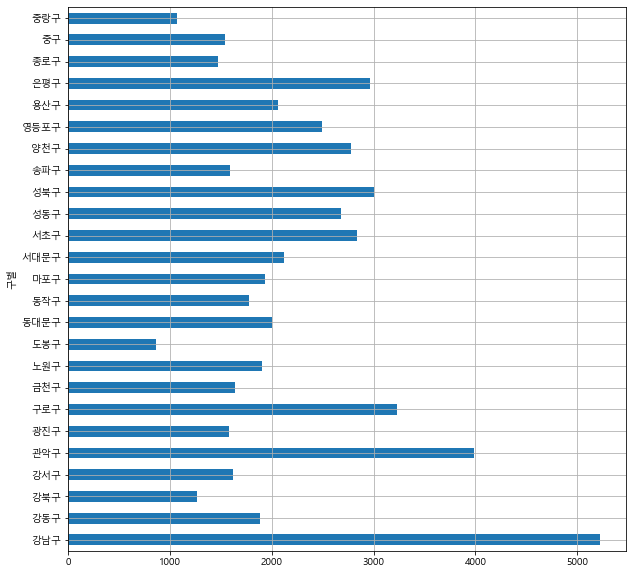

In [125]:
# CCTV 소계에 대한 막대 그래프 그리기
data_result['소계'].plot(kind = 'barh', grid = True, figsize = (10,10))

<AxesSubplot:ylabel='구별'>

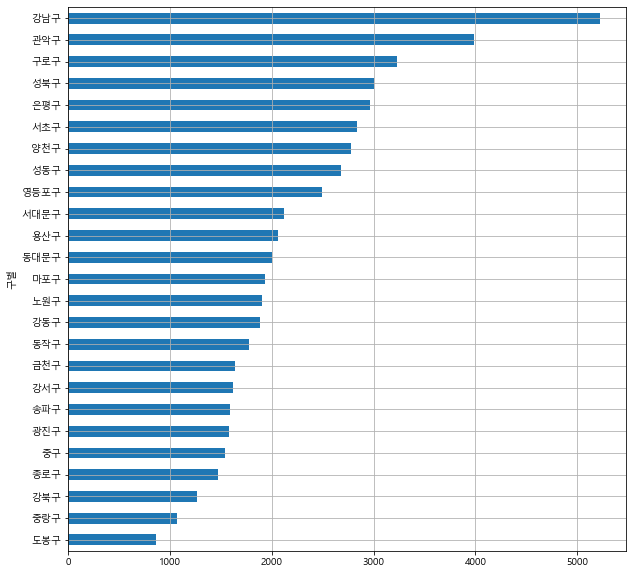

In [129]:
a = data_result.sort_values(by='소계', ascending=True)
a['소계'].plot(kind = 'barh', grid = True, figsize = (10,10))

---
# 인구대비 CCTV 비율

In [135]:
data_result['CCTV비율'] = data_result['소계'] / data_result['인구수']
data_result = data_result.sort_values(by = 'CCTV비율', ascending=True)

<AxesSubplot:ylabel='구별'>

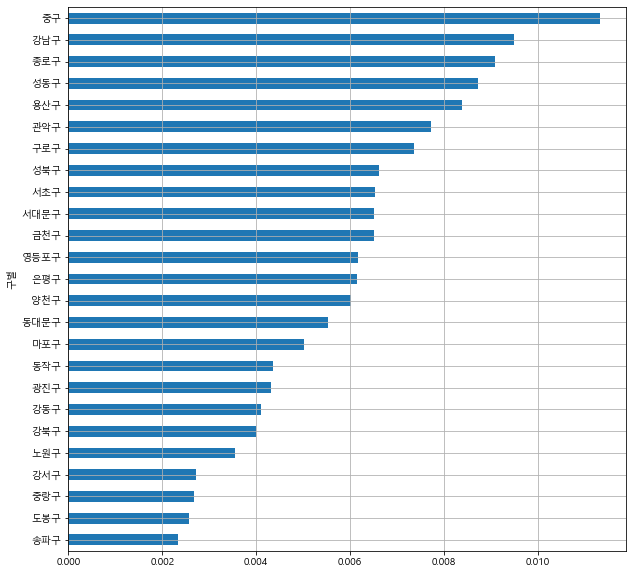

In [136]:
data_result['CCTV비율'].plot(kind = 'barh', grid = True, figsize = (10,10))

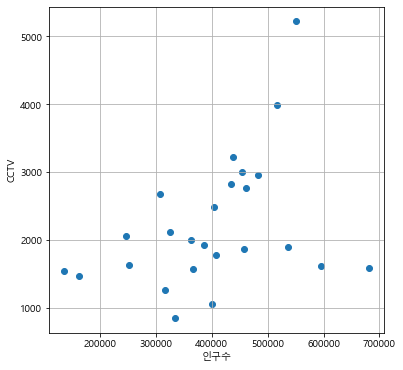

In [138]:
# 산점도를 이용한 시각화
plt.figure(figsize = (6,6))
plt.scatter(data_result['인구수'],data_result['소계'])
plt.xlabel('인구수')
plt.ylabel('CCTV')
plt.grid()
plt.show()

In [139]:
# 인구수, 소계에 따른 기준 직선(회귀선, 중심선) 만들기
fp1 = np.polyfit(data_result['인구수'],data_result['소계'],1)
fp1

array([2.88522756e-03, 1.06403852e+03])

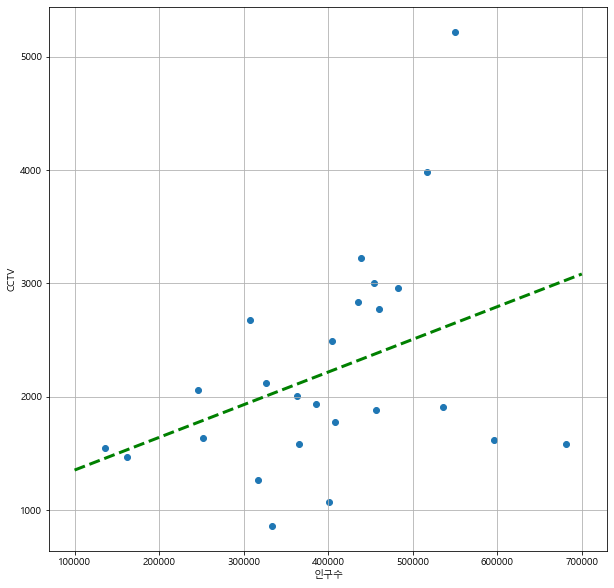

In [141]:
f1 = np.poly1d(fp1)   # 일차방정식
fx = np.linspace(100000,700000)

plt.figure(figsize = (10,10))
plt.scatter(data_result['인구수'],data_result['소계'])
plt.plot(fx, f1(fx), ls = 'dashed', lw = 3, color = 'g')  # 기준직선
plt.xlabel('인구수')
plt.ylabel('CCTV')
plt.grid()
plt.show()

> 기준선은 CCTV 댓수의 기존값입니다.    
> 이 직선을 기준으로 상위에 있는 점은 CCTV가 과하게 설치된 지역이고,    
> 직선보다 하위에 있는 점은 인구수에 비해 CCTV가 부족하다는 해석이 됩니다.

---
## 직선과의 오차를 구하는 공식과 오차가 큰 순으로 데이터 정렬 후 그래프 그리기

In [143]:
# 기준선 구하기
fp1 = np.polyfit(data_result['인구수'],data_result['소계'],1)

# y축 : CCTV 기준치 구하기
f1 = np.poly1d(fp1)

# x축 : 인구수
fx = np.linspace(100000,700000)

# 소계에서 기준 인구수 차이로 오차값 구하기
data_result['오차'] = np.abs(data_result['소계'] - f1(data_result['인구수']))

# 정렬
df_sort = data_result.sort_values(by = '오차', ascending=False)
df_sort.head()

,소계,최근 증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율,CCTV비율,오차
구별,,,,,,,,,,
강남구,5221,52.171379,549898,544804,5094,72602,0.009264,0.132028,0.009494,2570.380612
송파구,1586,62.833676,680883,674095,6788,89539,0.009969,0.131504,0.002329,1442.540920
관악구,3985,99.150425,516662,499374,17288,76664,0.033461,0.148383,0.007713,1430.274035
도봉구,858,66.601942,333495,331238,2257,60023,0.006768,0.179982,0.002573,1168.247488
강서구,1617,77.887789,595703,589302,6401,85992,0.010745,0.144354,0.002714,1165.777237


> ex) 강남구는 2570개가 적정하지만 5221개로 CCTV가 과다하게 보유하고 있음

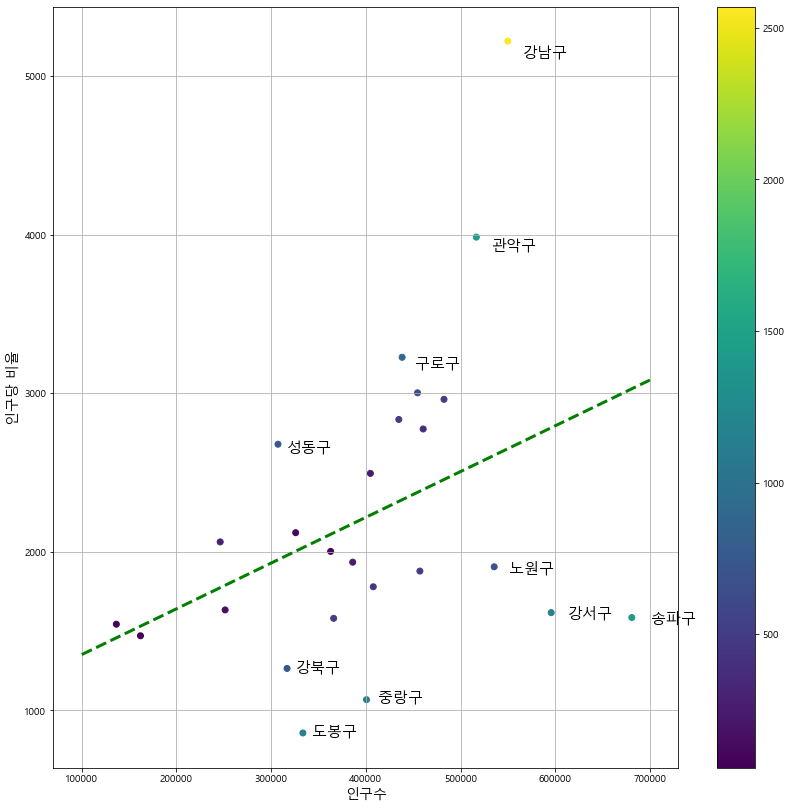

In [152]:
# 그래프에 텍스트와 color
plt.figure(figsize = (14,14))
plt.scatter(data_result['인구수'],data_result['소계'], c = data_result['오차'])  # c = 컬러 값

# x축 : 기준 인구수, y축 : CCTV 대수
plt.plot(fx,f1(fx),ls='dashed', lw=3, color = 'g')

# 오차가 가장 큰 10개 구에 텍스트 붙이기
for n in range(10):
    # scatter가 찍은 점에 적당한 거리를 조절하여 해당하는 데이터 인덱스를 출력
    plt.text(df_sort['인구수'][n] * 1.03, df_sort['소계'][n] *0.98, df_sort.index[n], fontsize=15)

plt.xlabel('인구수', fontsize = 14)
plt.ylabel('인구당 비율', fontsize = 14)
plt.colorbar()
plt.grid()
plt.show()

# 서울시에서 일어나는 범죄와 체감 안전도
강남 3구의 안전도가 얼마나 되는지 또한 서울시 전체의 안전도가 얼마나 되는지 확인

In [34]:
import pandas as pd
import numpy as np
import json
import folium
import seaborn as sns

In [2]:
crime_anal_police = pd.read_csv('./Data/crime_in_Seoul.csv', encoding='euc-kr', thousands=',')
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170
1,종로서,3,3,6,5,115,98,1070,413,1278,1070
2,남대문서,1,0,6,4,65,46,1153,382,869,794
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711
4,혜화서,3,2,5,4,96,63,1114,424,1015,861


In [3]:
station_name = [ ]
for name in crime_anal_police['관서명']:
    station_name.append('서울'+str(name[:-1])+'경찰서')
    
print(station_name)

['서울중부경찰서', '서울종로경찰서', '서울남대문경찰서', '서울서대문경찰서', '서울혜화경찰서', '서울용산경찰서', '서울성북경찰서', '서울동대문경찰서', '서울마포경찰서', '서울영등포경찰서', '서울성동경찰서', '서울동작경찰서', '서울광진경찰서', '서울서부경찰서', '서울강북경찰서', '서울금천경찰서', '서울중랑경찰서', '서울강남경찰서', '서울관악경찰서', '서울강서경찰서', '서울강동경찰서', '서울종암경찰서', '서울구로경찰서', '서울서초경찰서', '서울양천경찰서', '서울송파경찰서', '서울노원경찰서', '서울방배경찰서', '서울은평경찰서', '서울도봉경찰서', '서울수서경찰서']


In [4]:
# 서울시 경찰서 주소 불러오기
police_address = pd.read_csv('./Data/SeoulPoliceAddress.csv')
police_address.head()

,경찰관서,전화번호,FAX,주소
0,서울중부경찰서,(02)2273-4400,(02)2275-3009,서울 중구 수표로 27
1,서울종로경찰서,(02)3701-4324,(02)3701-4223,서울 종로구 율곡로 46
2,서울남대문경찰서,(02)2096-8324,(02)2096-8337,서울 중구 한강대로 410
3,서울서대문경찰서,(02)335-8192,(02)335-8189,서울 서대문구 통일로 113
4,서울혜화경찰서,(02)762-4400,(02)3158-7133,서울 종로구 창경궁로 112-16


In [5]:
SeoulPoliceAddress_latlong = pd.read_csv('./Data/SeoulPoliceAddress_latlong.csv')
SeoulPoliceAddress_latlong.head()

,경찰관서,전화번호,FAX,주소,lat,lng
0,서울중부경찰서,(02)2273-4400,(02)2275-3009,서울 중구 수표로 27,37.563514,126.989614
1,서울종로경찰서,(02)3701-4324,(02)3701-4223,서울 종로구 율곡로 46,37.575532,126.984929
2,서울남대문경찰서,(02)2096-8324,(02)2096-8337,서울 중구 한강대로 410,37.554819,126.973563
3,서울서대문경찰서,(02)335-8192,(02)335-8189,서울 서대문구 통일로 113,37.564902,126.966785
4,서울혜화경찰서,(02)762-4400,(02)3158-7133,서울 종로구 창경궁로 112-16,37.571876,126.998932


In [6]:
# station_name과 police_address의 경찰관서 순서와 이름이 같은지 확인
len(station_name == police_address['경찰관서'])

31

In [7]:
# 경찰관서의  주소중 구 이름만 추출하기
list = []
for i in SeoulPoliceAddress_latlong.주소:
    list.append(i.split()[1])
print(list)

['중구', '종로구', '중구', '서대문구', '종로구', '용산구', '성북구', '동대문구', '마포구', '영등포구', '성동구', '동작구', '광진구', '은평구', '강북구', '관악구', '중랑구', '강남구', '관악구', '양천구', '강동구', '성북구', '구로구', '서초구', '양천구', '송파구', '노원구', '서초구', '은평구', '도봉구', '강남구']


In [8]:
crime_anal_police['구별'] = list
crime_anal_police

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구
5,용산서,5,5,14,14,194,173,1557,587,2050,1704,용산구
6,성북서,2,2,2,1,86,71,953,409,1194,1015,성북구
7,동대문서,5,5,13,13,173,146,1981,814,2548,2227,동대문구
8,마포서,8,8,14,10,294,247,2555,813,2983,2519,마포구
9,영등포서,14,12,22,20,295,183,2964,978,3572,2961,영등포구


In [9]:
# 관서명과 구별이름 확인
crime_anal_police.loc[:,['관서명', '구별']]

,관서명,구별
0,중부서,중구
1,종로서,종로구
2,남대문서,중구
3,서대문서,서대문구
4,혜화서,종로구
5,용산서,용산구
6,성북서,성북구
7,동대문서,동대문구
8,마포서,마포구
9,영등포서,영등포구


In [10]:
# 금천서의 구별이 관악구로 되어 있는데 이름 금천구로 변경
# 금천서의 정보만 검색
crime_anal_police[crime_anal_police['관서명']=='금천서']

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
15,금천서,3,4,6,6,151,122,1567,888,2054,1776,관악구


In [11]:
# 금천서의 구별을 관악구에서 금천구로 변경, 강서서의 구별을 양천구에서 강서구로 변경
crime_anal_police.loc[15,"구별"] = '금천구'
crime_anal_police.loc[19,"구별"] = '강서구'
crime_anal_police[crime_anal_police['관서명']=='강서서']

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
19,강서서,7,8,13,13,262,191,2096,1260,3207,2718,강서구


In [12]:
# 정리가 되면 새로운 csv file로 저장
crime_anal_police.to_csv('./Data/Seoul_crime_include_gu_name.csv', index=False)

In [13]:
# 확인
pd.read_csv('./Data/Seoul_crime_include_gu_name.csv')

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구
5,용산서,5,5,14,14,194,173,1557,587,2050,1704,용산구
6,성북서,2,2,2,1,86,71,953,409,1194,1015,성북구
7,동대문서,5,5,13,13,173,146,1981,814,2548,2227,동대문구
8,마포서,8,8,14,10,294,247,2555,813,2983,2519,마포구
9,영등포서,14,12,22,20,295,183,2964,978,3572,2961,영등포구


> Key값은 구별 컬럼을 사용.    
> 따라서 관서명으로 데이터를 정리하는 것이 아니고 구별로 데이터를 정리 필요

In [14]:
# 서울시 경찰 관서 표시하기

map = folium.Map(location =[37.56, 126.97], zoom_start=11)

for n in SeoulPoliceAddress_latlong.index:
    folium.Marker([SeoulPoliceAddress_latlong['lat'][n], SeoulPoliceAddress_latlong['lng'][n]],
                  popup=SeoulPoliceAddress_latlong['경찰관서'][n]
                 ).add_to(map)

map

In [15]:
# 구별 합계 집계로 처리
crime_anal_police.drop('관서명', axis=1)
crime_anal = crime_anal_police.pivot_table(crime_anal_police.columns, index= '구별', aggfunc=sum)
crime_anal.head()

,강간 검거,강간 발생,강도 검거,강도 발생,살인 검거,살인 발생,절도 검거,절도 발생,폭력 검거,폭력 발생
구별,,,,,,,,,,
강남구,349,449,18,21,10,13,1650,3850,3705,4284
강동구,123,156,8,6,3,4,789,2366,2248,2712
강북구,126,153,13,14,8,7,618,1434,2348,2649
강서구,191,262,13,13,8,7,1260,2096,2718,3207
관악구,221,320,14,12,8,9,827,2706,2642,3298


In [16]:
# 구별 각 범죄별 검거율 구하기
crime_anal['강간검거율'] = crime_anal['강간 검거'] / crime_anal['강간 발생'] * 100
crime_anal['강도검거율'] = crime_anal['강도 검거'] / crime_anal['강도 발생'] * 100
crime_anal['살인검거율'] = crime_anal['살인 검거'] / crime_anal['살인 발생'] * 100
crime_anal['절도검거율'] = crime_anal['절도 검거'] / crime_anal['절도 발생'] * 100
crime_anal['폭력검거율'] = crime_anal['폭력 검거'] / crime_anal['폭력 발생'] * 100
crime_anal.head()

,강간 검거,강간 발생,강도 검거,강도 발생,살인 검거,살인 발생,절도 검거,절도 발생,폭력 검거,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,,,,,,
강남구,349,449,18,21,10,13,1650,3850,3705,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,123,156,8,6,3,4,789,2366,2248,2712,78.846154,133.333333,75.000000,33.347422,82.890855
강북구,126,153,13,14,8,7,618,1434,2348,2649,82.352941,92.857143,114.285714,43.096234,88.637222
강서구,191,262,13,13,8,7,1260,2096,2718,3207,72.900763,100.000000,114.285714,60.114504,84.752105
관악구,221,320,14,12,8,9,827,2706,2642,3298,69.062500,116.666667,88.888889,30.561715,80.109157


In [17]:
# 검거 건수는 삭제
del crime_anal['강간 검거']
del crime_anal['강도 검거']
del crime_anal['살인 검거']
del crime_anal['절도 검거']
del crime_anal['폭력 검거']
crime_anal.head()

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,133.333333,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,114.285714,43.096234,88.637222
강서구,262,13,7,2096,3207,72.900763,100.000000,114.285714,60.114504,84.752105
관악구,320,12,9,2706,3298,69.062500,116.666667,88.888889,30.561715,80.109157


> 전년도 발생한 사건의 검거 건수도 포함되어서 검거율이 100% 넘는 곳이 발생

In [18]:
# 검거율이 100이 넘는 경우에는 100으로 변경
updateList = ['강간검거율','강도검거율','살인검거율','절도검거율','폭력검거율']

for upd in updateList:
    crime_anal.loc[crime_anal[upd]>100,upd] = 100
crime_anal

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
강서구,262,13,7,2096,3207,72.900763,100.000000,100.000000,60.114504,84.752105
관악구,320,12,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157
광진구,240,14,4,3026,2625,91.666667,100.000000,100.000000,42.200925,83.047619
구로구,281,15,8,2335,3007,58.362989,73.333333,75.000000,38.072805,80.877951
금천구,151,6,3,1567,2054,80.794702,100.000000,100.000000,56.668794,86.465433
노원구,197,7,10,2193,2723,61.421320,100.000000,100.000000,36.525308,85.530665


In [19]:
# column 이름 변경하기
# 강간 발생을 강간, 강도 발생을 강도, 살인 발생을 살인, 절도 발생을 절도, 폭력 발생을 폭력으로 바꾸기
crime_anal.rename (columns={'강간 발생': '강간',
                      '강도 발생': '강도',
                      '살인 발생': '살인',
                      '절도 발생': '절도',
                      '폭력 발생': '폭력',
                     }, inplace=True)
crime_anal.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
강서구,262,13,7,2096,3207,72.900763,100.000000,100.000000,60.114504,84.752105
관악구,320,12,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157


----
# 데이터의 정규화(Normalize)
- 강도와 살인은 2자릿수 이나 절도와 폭력은 4자리 입니다.
- 각각의 범죄 발생 건수를 비슷한 범위에 놓고 비교하는 것이 편리 합니다.
- 각 항목의 값을 최대 1로 계산하여 그 비중 자체로 분석하는 것이 좋습니다.

## 머신러닝 모듈 사용하기


In [21]:
# sklearn의 preprocessing 기능을 사용하면 최대값과 최소값을 비교하면서 정규화를 진행.
from sklearn import preprocessing

In [22]:
# 정규화를 진행할 컬럼 설정 
col = ['강간','강도','살인','절도','폭력']

In [23]:
# 정규화를 진행할 컬럼 및 데이터 설정
x = crime_anal[col].values
x

array([[ 449,   21,   13, 3850, 4284],
       [ 156,    6,    4, 2366, 2712],
       [ 153,   14,    7, 1434, 2649],
       [ 262,   13,    7, 2096, 3207],
       [ 320,   12,    9, 2706, 3298],
       [ 240,   14,    4, 3026, 2625],
       [ 281,   15,    8, 2335, 3007],
       [ 151,    6,    3, 1567, 2054],
       [ 197,    7,   10, 2193, 2723],
       [ 102,    9,    3, 1063, 1487],
       [ 173,   13,    5, 1981, 2548],
       [ 285,    9,    5, 1865, 1910],
       [ 294,   14,    8, 2555, 2983],
       [ 154,    5,    2, 1812, 2056],
       [ 393,    9,    8, 2635, 2399],
       [ 126,    9,    4, 1607, 1612],
       [ 150,    5,    5, 1785, 2209],
       [ 220,   13,   11, 3239, 3295],
       [ 120,    6,    3, 1890, 2509],
       [ 295,   22,   14, 2964, 3572],
       [ 194,   14,    5, 1557, 2050],
       [ 166,    9,    3, 1914, 2653],
       [ 211,   11,    6, 2184, 2293],
       [ 170,    9,    3, 2548, 2224],
       [ 187,   11,   13, 2135, 2847]], dtype=int64)

In [24]:
# 최대값괴 최소값의 스케일 값 가져오기
min_max_scaler = preprocessing.MinMaxScaler()

In [25]:
# 정규화 시킬 최종값은 비율로 계산되기 때문에 float로 설정
x_scaled = min_max_scaler.fit_transform(x.astype(float))
x_scaled

array([[1.        , 0.94117647, 0.91666667, 1.        , 1.        ],
       [0.1556196 , 0.05882353, 0.16666667, 0.46752781, 0.43796925],
       [0.14697406, 0.52941176, 0.41666667, 0.13311805, 0.41544512],
       [0.4610951 , 0.47058824, 0.41666667, 0.37064944, 0.61494458],
       [0.62824207, 0.41176471, 0.58333333, 0.58952278, 0.64747944],
       [0.39769452, 0.52941176, 0.16666667, 0.70434159, 0.4068645 ],
       [0.51585014, 0.58823529, 0.5       , 0.45640474, 0.5434394 ],
       [0.14121037, 0.05882353, 0.08333333, 0.18083961, 0.2027172 ],
       [0.27377522, 0.11764706, 0.66666667, 0.40545389, 0.44190204],
       [0.        , 0.23529412, 0.08333333, 0.        , 0.        ],
       [0.20461095, 0.47058824, 0.25      , 0.32938644, 0.379335  ],
       [0.52737752, 0.23529412, 0.25      , 0.28776462, 0.15123346],
       [0.55331412, 0.52941176, 0.5       , 0.53534266, 0.53485878],
       [0.14985591, 0.        , 0.        , 0.26874776, 0.20343225],
       [0.83861671, 0.23529412, 0.

In [26]:
# 정규화된 범죄건수가 들어 있는 새로운 데이터프레임 생성
crime_anal_norm = pd.DataFrame(x_scaled, columns=col, index = crime_anal.index)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력
구별,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000
강동구,0.155620,0.058824,0.166667,0.467528,0.437969
강북구,0.146974,0.529412,0.416667,0.133118,0.415445
강서구,0.461095,0.470588,0.416667,0.370649,0.614945
관악구,0.628242,0.411765,0.583333,0.589523,0.647479


In [27]:
# 기존에 있던 검거율 컬럼을 이용하여 새롭게 만드는 crime_anal_norm에 추가
col2 = ['강간검거율','강도검거율','살인검거율','절도검거율','폭력검거율']
crime_anal_norm[col2] = crime_anal[col2]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157


-----
# CCTV 데이터와 합치기
: 구별 CCTV 수와 인구수를 가져와서 범죄율과 얼마나 상관성이 있는지 확인
    

In [29]:
result_CCTV = pd.read_csv('./Data/CCTV_result.csv', index_col='구별')
result_CCTV.head()

,소계,최근 증가율,인구수,한국인,외국인,고령자,외국인비율,고령자비율
구별,,,,,,,,
강남구,5221,52.171379,549898,544804,5094,72602,0.009264,0.132028
강동구,1879,82.960078,457042,452646,4396,66401,0.009618,0.145284
강북구,1265,83.068017,316750,312985,3765,61660,0.011886,0.194665
강서구,1617,77.887789,595703,589302,6401,85992,0.010745,0.144354
관악구,3985,99.150425,516662,499374,17288,76664,0.033461,0.148383


In [30]:
crime_anal_norm[['인구수','CCTV']] = result_CCTV[['인구수','소계']]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV
구별,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,549898,5221
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,457042,1879
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,316750,1265
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,595703,1617
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,516662,3985


In [31]:
# 정규화된 범죄 발생건수를 합하여 범죄 컬럼을 생성
col = ['강간','강도','살인','절도','폭력']
crime_anal_norm['범죄'] = np.sum(crime_anal_norm[col], axis = 1)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄
구별,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,549898,5221,4.857843
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,457042,1879,1.286607
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,316750,1265,1.641616
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,595703,1617,2.333944
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,516662,3985,2.860342


In [32]:
# 검거율도 통합하여 컬럼 생성
col = ['강간검거율','강도검거율','살인검거율','절도검거율','폭력검거율']
crime_anal_norm['검거'] = np.sum(crime_anal_norm[col], axis = 1)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,549898,5221,4.857843,369.707384
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,457042,1879,1.286607,370.084431
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,316750,1265,1.641616,406.943540
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,595703,1617,2.333944,417.767372
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,516662,3985,2.860342,368.622261


In [62]:
np.corrcoef(crime_anal_norm.CCTV,crime_anal_norm.범죄)

array([[1.        , 0.48690374],
       [0.48690374, 1.        ]])

# Seaborn을 활용한 시각화

In [33]:
# 한글 폰트 문제 해결 
# matplotlib은 한글 폰트를 지원하지 않음
# os정보
import platform
# font_manager : 폰트 관리 모듈
# rc : 폰트 변경 모듈
from matplotlib import font_manager, rc
# 시각화 도구
from matplotlib import pyplot as plt
%matplotlib inline

# unicode 설정
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic') # os가 macos
elif platform.system() == 'Windows':
    path = 'c:/Windows/Fonts/malgun.ttf' # os가 windows
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
else:
    print("Unknown System")

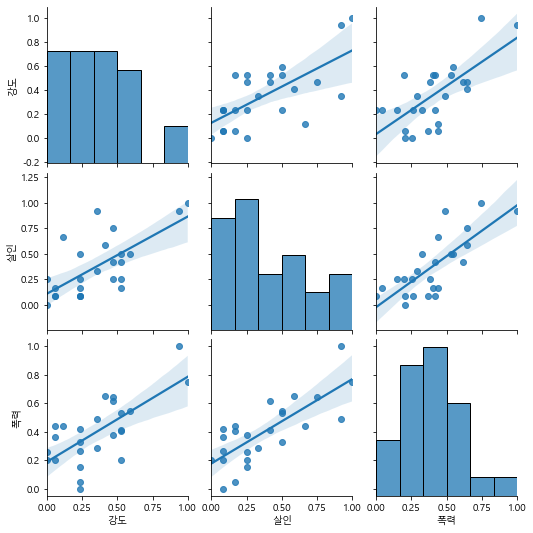

In [35]:
# 강도, 살인, 폭력 건수에 대한 상관관계 
crime_pair = crime_anal_norm[['강도','살인','폭력']]

# 조건에 따라 그리드 나누기
sns.pairplot(crime_pair, kind='reg')

> 강도와 폭력, 살인과 폭력, 강도와 살인 모두 양의 상관관계.    
> 즉 강도의 건수가 많아지면 폭력과 살인의 발생건수도 많아진다.

## CCTV와 살인, 강도에 대한 그래프

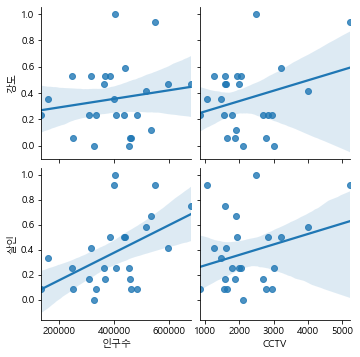

In [36]:
sns.pairplot(crime_anal_norm, kind='reg',x_vars=['인구수','CCTV'], y_vars=['강도','살인'])

> 인구수가 증가하면 살인과 강도의 발생 수도 증가한다.     
> 강도 보다는 살인 발생수가 훨씬 많이 증가한다.    
> CCTV와 살인은 상관관계가 있으나 인구수 대비 상관관계가 낮게 보입니다.(기울기 확인)        
> 따라서 CCTV가 없을 때 살인 사건 발생 수가 증가한다.

## 인구수와 살인 및 폭력 검거율을 확인

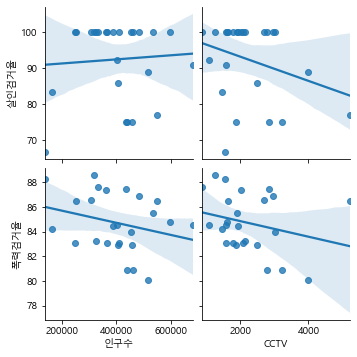

In [37]:
sns.pairplot(crime_anal_norm, kind='reg',x_vars=['인구수','CCTV'], y_vars=['살인검거율','폭력검거율'])

> 음의 상관계수가 발생합니다.   
> 인구수가 많아 질수록 폭력 검거율은 줄어들고.   
> CCTV가 많아 질수록 모든 검거율이 낮아집니다.

--- 
# heatmap을 이용한 전체 검거율 확인


In [39]:
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,1.000000,1.000000,77.728285,85.714286,76.923077,42.857143,86.484594,549898,5221,4.857843,369.707384
강동구,0.155620,0.058824,0.166667,0.467528,0.437969,78.846154,100.000000,75.000000,33.347422,82.890855,457042,1879,1.286607,370.084431
강북구,0.146974,0.529412,0.416667,0.133118,0.415445,82.352941,92.857143,100.000000,43.096234,88.637222,316750,1265,1.641616,406.943540
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.000000,100.000000,60.114504,84.752105,595703,1617,2.333944,417.767372
관악구,0.628242,0.411765,0.583333,0.589523,0.647479,69.062500,100.000000,88.888889,30.561715,80.109157,516662,3985,2.860342,368.622261


In [40]:
# 검거 최대값 가져오기
tmp_max = crime_anal_norm['검거'].max()
tmp_max

432.593167122272

In [41]:
# 검거의 최대값을 100으로 설정하고 검거율 계산
crime_anal_norm['검거'] = crime_anal_norm['검거'] / 100
# 검거를 기준으로 정렬하기
crime_anal_norm_sort = crime_anal_norm.sort_values(by='검거', ascending=False)
crime_anal_norm_sort.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
도봉구,0.000000,0.235294,0.083333,0.000000,0.000000,100.000000,100.0,100.0,44.967074,87.626093,333495,858,0.318627,4.325932
금천구,0.141210,0.058824,0.083333,0.180840,0.202717,80.794702,100.0,100.0,56.668794,86.465433,251370,1634,0.666924,4.239289
강서구,0.461095,0.470588,0.416667,0.370649,0.614945,72.900763,100.0,100.0,60.114504,84.752105,595703,1617,2.333944,4.177674
광진구,0.397695,0.529412,0.166667,0.704342,0.406864,91.666667,100.0,100.0,42.200925,83.047619,365990,1581,2.204979,4.169152
동대문구,0.204611,0.470588,0.250000,0.329386,0.379335,84.393064,100.0,100.0,41.090358,87.401884,362793,2003,1.633921,4.128853


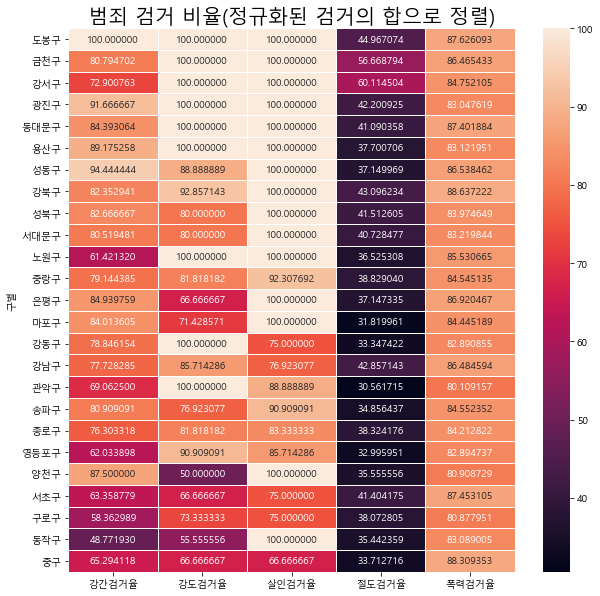

In [42]:
# 히트맵 그리기
col = ['강간검거율','강도검거율','살인검거율','절도검거율','폭력검거율']
plt.figure(figsize=(10,10))
sns.heatmap(crime_anal_norm_sort[col],
           annot = True,  # 데이터 값 표시 여부
           fmt = 'f', # d = 정수형 포맷
           linewidths = 0.5, # 구분선 두께
           cbar =True, # 컬러 바 표시여부
           
           )
plt.title('범죄 검거 비율(정규화된 검거의 합으로 정렬)', fontsize = 20)
plt.show()

## Heatmap을 이용한 범죄비율 확인

In [43]:
# 이전 범죄 컬럼의 합을 5로 나누어 주어야 함 
crime_anal_norm_sort['범죄'] = crime_anal_norm_sort['범죄'] / 5
crime_anal_norm_sort = crime_anal_norm_sort.sort_values(by = '범죄', ascending=False)

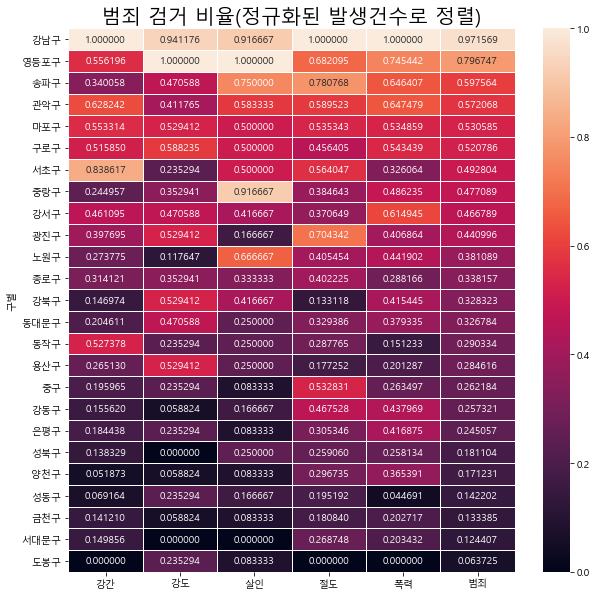

In [44]:
# 히트맵 그리기
col = ['강간','강도','살인','절도','폭력','범죄']
plt.figure(figsize=(10,10))
sns.heatmap(crime_anal_norm_sort[col],
           annot = True,  # 데이터 값 표시 여부
           fmt = 'f', # d = 정수형 포맷
           linewidths = 0.5, # 구분선 두께
           cbar =True, # 컬러 바 표시여부
            
           
           )
plt.title('범죄 검거 비율(정규화된 발생건수로 정렬)', fontsize = 20)
plt.show()

# 지도 출력

In [47]:
geo_path = './Data/skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding='utf-8'))

In [48]:
# 살인 건수를 서울시 지도에 출력
map = folium.Map(location=[37.55,126.98],
                 zoom_start=11,
                 tiles='stamen Toner'
                )
folium.Choropleth(geo_data=geo_str,
                 data=crime_anal_norm['살인'],
                 columns=[crime_anal_norm.index,crime_anal_norm['살인']],
                  fill_color='PuRd',
                  key_on = 'feature.id'
                 ).add_to(map)
map

In [49]:
# 강간 건수를 서울시 지도에 출력
map = folium.Map(location=[37.55,126.98],
                 zoom_start=11,
                 tiles='stamen Toner'
                )
folium.Choropleth(geo_data=geo_str,
                 data=crime_anal_norm['강간'],
                 columns=[crime_anal_norm.index,crime_anal_norm['강간']],
                  fill_color='PuRd',
                  key_on = 'feature.id'
                 ).add_to(map)
map

In [50]:
# 범죄 건수를 서울시 지도에 출력
map = folium.Map(location=[37.55,126.98],
                 zoom_start=11,
                 tiles='stamen Toner'
                )
folium.Choropleth(geo_data=geo_str,
                 data=crime_anal_norm_sort['범죄'],
                 columns=[crime_anal_norm.index,crime_anal_norm_sort['범죄']],
                  fill_color='PuRd',
                  key_on = 'feature.id'
                 ).add_to(map)
map

In [51]:
# 인구대비 범죄율 출력 : 범죄 / 인구수
tmp_criminal = crime_anal_norm['범죄'] / crime_anal_norm['인구수'] * 100000 # 10만명당 범죄 발생비율
map = folium.Map(location=[37.55,126.98],
                 zoom_start=11,
                 tiles='stamen Toner'
                )
folium.Choropleth(geo_data=geo_str,
                 data=tmp_criminal,
                 columns=[crime_anal_norm.index,tmp_criminal],
                  fill_color='PuRd',
                  key_on = 'feature.id'
                 ).add_to(map)
map

# 서울시 경찰서별 검거율과 구별 범죄 발생율의 시각화

In [52]:
# 경찰서의 위경도 저장
crime_anal_raw = crime_anal_police.copy()
crime_anal_raw.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


In [53]:
crime_anal_raw['lat'] = SeoulPoliceAddress_latlong['lat']
crime_anal_raw['lng'] = SeoulPoliceAddress_latlong['lng']
crime_anal_raw.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별,lat,lng
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구,37.563514,126.989614
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구,37.575532,126.984929
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구,37.554819,126.973563
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구,37.564902,126.966785
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구,37.571876,126.998932


In [54]:
# 통합 검거율 구하기
col = ['살인 검거','강도 검거','강간 검거','절도 검거','폭력 검거']
tmp = crime_anal_raw[col] / crime_anal_raw[col].max()
crime_anal_raw['검거'] = np.sum(tmp, axis = 1)
crime_anal_raw.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별,lat,lng,검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구,37.563514,126.989614,1.275416
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구,37.575532,126.984929,1.523847
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구,37.554819,126.973563,0.907372
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구,37.564902,126.966785,1.978299
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구,37.571876,126.998932,1.198382


In [55]:
# 각 경찰서별 위치 확인

map = folium.Map(location =[37.56, 126.97], zoom_start=11)

for n in crime_anal_raw.index:
    folium.Marker([crime_anal_raw['lat'][n], crime_anal_raw['lng'][n]],
                  popup=crime_anal_raw['관서명'][n],
                  icon=folium.Icon(color=  'red')
                 ).add_to(map)
    # 검거율을 원의 넓이로 표현하기
    folium.CircleMarker([crime_anal_raw['lat'][n], crime_anal_raw['lng'][n]],
                        radius=(crime_anal_raw['검거'][n]*10), popup = crime_anal_raw['검거'][n], color = 'red',
                        fill = True, fill_color = 'yellow'
                       ).add_to(map)
folium.Choropleth(geo_data=geo_str,
                 data=crime_anal_norm_sort['범죄'],
                 columns=[crime_anal_norm.index,crime_anal_norm_sort['범죄']],
                  fill_color='PuRd',
                  key_on = 'feature.id'
                 ).add_to(map)
map